# **NER_by_BI_LSTM_CRF**

## **Author:** Gema De Vargas Romero

## **Master Thesis:** "Development of a Named Entity Recognition System to automatically assign tumor morphology entity mentions to health-related documents in Spanish." 

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

path='drive/My Drive/Ejemplos NER - TFM/'
!ls 'drive/My Drive/Ejemplos NER - TFM/'

Mounted at /content/drive/
 bert
 check_results2.ipynb
 check_results.ipynb
 data
 dev_set
 dev_set2
'Dictionary based NER (spacy).ipynb'
'Ehealth_Dictionary based NER (spacy).ipynb'
 last_step_cantemist.ipynb
 last_step_cantemist_TEST.ipynb
 mismatch_bert.xlsx
 mismatch_bilstm1.xlsx
 mismatch_bilstm2.xlsx
 mismatch_bilstm3.xlsx
 NER_by_BERT_Cantemist_BIOESV.ipynb
 NER_by_BERT_Cantemist_Competicion.ipynb
 NER_by_BERT_Cantemist.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_BIOESV_2.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_BIOESV.ipynb
 NER_by_BI_LSTM_CRF_Cantemist_Competicion.ipynb
 NER_by_BI_LSTM_CRF_Cantemist.ipynb
 NER_by_CRF_Cantemist_Competicion.ipynb
 NER_by_CRF_Cantemist.ipynb
 NER_by_CRF.ipynb
 Preprocessing_NER_Cantemist.ipynb
 resources
 results_bert
 results_bert2
 results_BILSTM_ap1
 results_BILSTM_ap2
 results_BILSTM_ap3
 results_CRF
 sample_set
 Scielo+Wiki_skipgram_cased.bin
 Scielo+Wiki_skipgram_cased.vec
 test-background-set-to-publish
 test_set
 test_set_predictions
 train_set


## **Loading libraries**

First, we must load the libraries that we will use in this notebook:

In [2]:
!pip install sklearn-crfsuite
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_precision_score
from sklearn_crfsuite.metrics import flat_recall_score
from sklearn_crfsuite.metrics import flat_classification_report
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

     |████████████████████████████████| 747kB 4.0MB/s 


In [3]:
# Library spacy
!pip install -U spacy 
#!python -m spacy validate
!python -m spacy download es_core_news_lg

import spacy

# nlp = spacy.load("es") # no longer works with updated version of spacy 2.3.1
import es_core_news_lg
nlp = es_core_news_lg.load()

     |████████████████████████████████| 10.0MB 2.7MB/s 
     |████████████████████████████████| 2.1MB 46.4MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 573.1MB 1.3MB/s 
  Created wheel for es-core-news-lg: filename=es_core_news_lg-2.3.1-cp36-none-any.whl size=573139081 sha256=54d09cf13f8d12edeab96c9feeaa613771f4065fbe44a9acd9a155cf12c648b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-846a9t9a/wheels/48/59/33/558e7f48e924c6cac0cbd3679ee7c84f5ae02964c335232e5a
Successfully built es-core-news-lg
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_lg')


## **Read the files**

In [4]:
!ls 'drive/My Drive/Ejemplos NER - TFM/data'
import pickle as pkl

df_data_complete.csv	files_txt_dev	     sentences_dev_by_cc2
df_data_dev2_2.csv	files_txt_test	     sentences_test
df_data_dev2.csv	files_txt_test_true  sentences_test_by_cc
df_data_test.csv	sentences_dev	     sentences_test_true
df_data_test_true2.csv	sentences_dev2	     sentences_test_true_by_cc
df_data_train2.csv	sentences_dev_by_cc  sentences_train


In [5]:
# Train dataset
with open(path+'data/sentences_train', 'rb') as file: 
  sentences_train = pkl.load(file)
file.close()

df_data_train2 = pd.read_csv(path+'data/df_data_train2.csv')

In [6]:
# Development dataset 1
with open(path+'data/sentences_dev', 'rb') as file: 
  sentences_dev = pkl.load(file)
file.close()

with open(path+'data/sentences_dev_by_cc', 'rb') as file: 
  sentences_dev_by_cc = pkl.load(file)
file.close()

df_data_dev2 = pd.read_csv(path+'data/df_data_dev2.csv')

In [7]:
# Development dataset 2
with open(path+'data/sentences_dev2', 'rb') as file: 
  sentences_dev2 = pkl.load(file)
file.close()

with open(path+'data/sentences_dev_by_cc2', 'rb') as file: 
  sentences_dev_by_cc2 = pkl.load(file)
file.close()

df_data_dev2_2 = pd.read_csv(path+'data/df_data_dev2_2.csv')

In [8]:
# TEST and background FILES:
with open(path+'data/sentences_test', 'rb') as file: 
  sentences_test = pkl.load(file)
file.close()

with open(path+'data/sentences_test_by_cc', 'rb') as file: 
  sentences_test_by_cc = pkl.load(file)
file.close()

df_data_test = pd.read_csv(path+'data/df_data_test.csv')

23.306840324069327
220


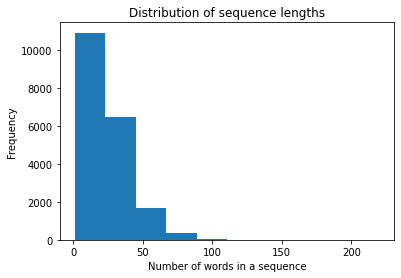

In [9]:
len_sent_train = [len(sent) for sent in sentences_train]
plt.hist(len_sent_train)
plt.title("Distribution of sequence lengths")
plt.xlabel("Number of words in a sequence")
plt.ylabel("Frequency")

print(np.mean(len_sent_train))
print(np.max(len_sent_train))

23.612403100775193
142


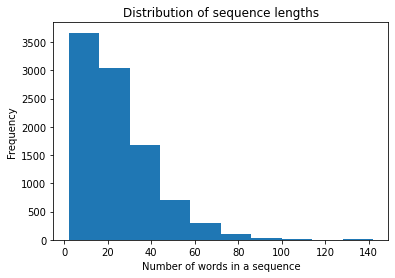

In [10]:
len_sent_dev = [len(sent) for sent in sentences_dev]
plt.hist(len_sent_dev)
plt.title("Distribution of sequence lengths")
plt.xlabel("Number of words in a sequence")
plt.ylabel("Frequency")

print(np.mean(len_sent_dev))
print(np.max(len_sent_dev))

21.099401059663673
161


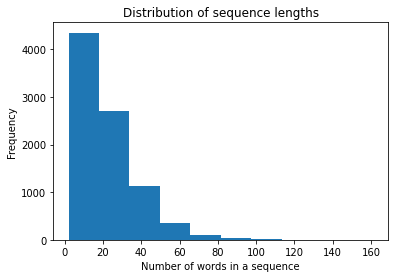

In [11]:
len_sent_dev2 = [len(sent) for sent in sentences_dev2]
plt.hist(len_sent_dev2)
plt.title("Distribution of sequence lengths")
plt.xlabel("Number of words in a sequence")
plt.ylabel("Frequency")

print(np.mean(len_sent_dev2))
print(np.max(len_sent_dev2))

## **COMBINE TRAIN AND DEVELOPMENT FILES TO FEED FINAL MODEL**

In [12]:
df_data_complete = pd.read_csv(path+'data/df_data_complete.csv')

In [13]:
df_data_complete

,File_Index,Sentence_Index,Word,POS,start,Tag
0,1,1,ANAMNESIS,NOUN,0,O
1,1,1,\n,SPACE,9,O
2,1,1,Mujer,NOUN,10,O
3,1,1,de,ADP,16,O
4,1,1,67,NUM,19,O
...,...,...,...,...,...,...
862674,1001,37730,exitus,NOUN,5646,O
862675,1001,37730,de,ADP,5653,O
862676,1001,37730,la,DET,5656,O
862677,1001,37730,paciente,NOUN,5659,O


In [14]:
print("Number of sentences in training dataset 1: %d" %len(sentences_train))
print("Number of sentences in development dataset 1: %d" %len(sentences_dev))
print("Number of sentences in development dataset 2: %d" %len(sentences_dev2))

Number of sentences in training dataset 1: 19502
Number of sentences in development dataset 1: 9546
Number of sentences in development dataset 2: 8682


In [15]:
print(sentences_dev[0])

[('Anamnesis', 'NOUN', 'O', 0), ('\n', 'SPACE', 'O', 9), ('Varón', 'PROPN', 'O', 10), ('de', 'ADP', 'O', 16), ('74', 'NUM', 'O', 19), ('años', 'NOUN', 'O', 22), (',', 'PUNCT', 'O', 26), ('exfumador', 'NOUN', 'O', 28), ('desde', 'ADP', 'O', 38), ('hace', 'AUX', 'O', 44), ('15', 'NUM', 'O', 49), ('años', 'NOUN', 'O', 52), (',', 'PUNCT', 'O', 56), ('con', 'ADP', 'O', 58), ('único', 'ADJ', 'O', 62), ('antecedente', 'NOUN', 'O', 68), ('de', 'ADP', 'O', 80), ('hipertensión', 'NOUN', 'O', 83), (',', 'PUNCT', 'O', 95), ('dislipemia', 'NOUN', 'O', 97), ('y', 'CCONJ', 'O', 108), ('apendicectomizado', 'ADJ', 'O', 110), (';', 'PUNCT', 'O', 127), ('se', 'PRON', 'O', 129), ('diagnostica', 'VERB', 'O', 132), ('en', 'ADP', 'O', 144), ('marzo', 'INTJ', 'O', 147), ('de', 'ADP', 'O', 153), ('2013', 'NUM', 'O', 156), ('de', 'ADP', 'O', 161), ('carcinoma', 'INTJ', 'B-MOR', 164), ('de', 'ADP', 'I-MOR', 174), ('células', 'NOUN', 'I-MOR', 177), ('transicionales', 'ADJ', 'I-MOR', 185), ('de', 'ADP', 'I-MOR', 2

In [16]:
sentences_complete = sentences_train.copy()
sentences_complete.extend(sentences_dev)
sentences_complete.extend(sentences_dev2)

In [17]:
print("Number of sentences in training dataset 1: %d" %len(sentences_train))
print("Number of sentences in development dataset 1: %d" %len(sentences_dev))
print("Number of sentences in development dataset 2: %d" %len(sentences_dev2))
print("Number of sentences in combined dataset: %d" %len(sentences_complete))

Number of sentences in training dataset 1: 19502
Number of sentences in development dataset 1: 9546
Number of sentences in development dataset 2: 8682
Number of sentences in combined dataset: 37730


## **Model 2: BI-LSTM-CRF**

BI-LSTM-CRF combines the bidirectional LSTM model with the CRF model. This is a state-of-the approach to named entity recognition. The LSTM (Long Short Term Memory) is a special type of Recurrent Neural Network to process the sequence of data.

**Reference:**

https://www.aitimejournal.com/@akshay.chavan/complete-tutorial-on-named-entity-recognition-ner-using-python-and-keras

https://github.com/Akshayc1/named-entity-recognition/blob/master/NER%20using%20Bidirectional%20LSTM%20-%20CRF%20.ipynb

-----

**Keras:** https://keras.io/about/

Keras is a deep learning API written in python that runs on top of Tensorflow, which is an end-to-end, open-source machine learning platform. A key advantage of Keras is that it provides 

Keras is structured into layers and models.

**keras - contrib**

keras-contrib contains additional layers, activations, loss functions, optimizers, etc. that are not yet available within Keras itself. These additional modules can be used core Keras models and modules.

An linear chain CRF is defined to maximize the following likelihood function:

$$ L(W, U, b; y_1, ..., y_n) := \frac{1}{Z}
    \sum_{y_1, ..., y_n} \exp(-a_1' y_1 - a_n' y_n - \sum_{k=1^n}((f(x_k' W + b) y_k) + y_1' U y_2)), $$
    where:
        $Z$: normalization constant
        $x_k, y_k$:  inputs and outputs

### **Loading libraries**

sequeval allows to compute f1 score for named-entity recognition in Keras

In [18]:
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

!pip install gensim
import gensim

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-lsfgqd4o
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-lsfgqd4o
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=715a6152821860266ad70f9e77f93bf91c11f045e7cc15a47c9cffbc945c4207
  Stored in directory: /tmp/pip-ephem-wheel-cache-te8ectli/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=0efefe77905ed781dc3c3122813119a8fdcc312ece3725b1f7e6fc96cab76fd8
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [19]:
from gensim.models import Word2Vec

### **Model parameters:**


In [20]:
len_sent_train = [len(sent) for sent in sentences_train]
len_sent_dev = [len(sent) for sent in sentences_dev]
len_sent_dev2 = [len(sent) for sent in sentences_dev2]
len_sent_test = [len(sent) for sent in sentences_test]


print("Maximum sentence length in train set: %d" %max(len_sent_train))
print("Average sentence length in train set: %d" %np.mean(len_sent_train))
print()
print("Maximum sentence length in development set: %d" %max(len_sent_dev))
print("Average sentence length in development set: %d" %np.mean(len_sent_dev))
print()
print("Maximum sentence length in development set2: %d" %max(len_sent_dev2))
print("Average sentence length in development set2: %d" %np.mean(len_sent_dev2))
print()
print("Maximum sentence length in test set: %d" %max(len_sent_test))
print("Average sentence length in test set: %d" %np.mean(len_sent_test))

Maximum sentence length in train set: 220
Average sentence length in train set: 23

Maximum sentence length in development set: 142
Average sentence length in development set: 23

Maximum sentence length in development set2: 161
Average sentence length in development set2: 21

Maximum sentence length in test set: 267
Average sentence length in test set: 24


In [21]:
batch_size = 64
epochs = 8
max_len = 75
embedding = 40

In [22]:
preprocess = False

### **Model architecture**
https://keras.io/api/layers/core_layers/embedding/

**1. Embedding layer**

**2. Bidirectional layer**

**3. TimeDistributed layer**


### **Approach 1: BI-LSTM-CRF with random initialization of vectors**

Text files needs to be read into string tensors, then split into words. Finally, the words need to be indexed & turned into integer tensors.

Keras accepts numpy arrays.

- **word_to_index**: is a dictionary to convert a word into an index value.
- **tag_to_index** is a dictionary to convert a label into an index value. 

As a result, each word is represented as integer.

#### **Preprocessing the data**

In [23]:
def split_sentences(sentences): 
  sentences2 = []
  for sent in sentences:
    if len(sent) > 2.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:2*max_len])
      sentences2.append(sent[2*max_len:])

    elif len(sent) > 1.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:])

    else:
      sentences2.append(sent)
  return sentences2

In [ ]:
#sentences_train = split_sentences(sentences_train)
#sentences_dev = split_sentences(sentences_dev)

#sentences_dev_by_cc = []
#for cc in sentences_dev_by_cc:
#  sentences_dev_by_cc.append(split_sentences(cc))

#### **Train and evaluate the BiLSTM-CRF approach 1 model**

##### **Feature preparation**

**Train set**

In [24]:
#Getting unique words and labels from data 
words = list(df_data_train2['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
          
tags = list(df_data_train2['Tag'].unique())

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [25]:
# Converting each sentence into list of index from list of tokens
X_train = [[word_to_index.get(w[0], 1) for w in s] for s in sentences_train]

# Padding each sequence to have same length  of each word
X_train = pad_sequences(maxlen = max_len, sequences = X_train, padding = "post", value = word_to_index["PAD"])

#Convert label to index
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_train]

# padding
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", value = tag_to_index["PAD"])

num_tag = df_data_train2['Tag'].nunique()

# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tag + 1) for i in y_train]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [26]:
X_train[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  5, 11, 12, 13,  8, 14, 15, 16,
       17,  5, 18, 19, 20, 21, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [27]:
print(tag_to_index)

{'O': 1, 'B-MOR': 2, 'E-MOR': 3, 'S-MOR': 4, 'I-MOR': 5, 'V-MOR': 6, 'PAD': 0}


**Development set**

In [28]:
# DEVELOPMENT SET (without considering clinical cases independently)

# Converting each sentence into list of index from list of tokens
X_dev = [[word_to_index.get(w[0], 1) for w in s] for s in sentences_dev] 
# if the word is not in the vocabulary, is set to 1, which is the label "UNK" (unknown)

# Padding each sequence to have same length of each word
X_dev = pad_sequences(maxlen = max_len, sequences = X_dev, padding = "post", value = tag_to_index["PAD"])

# Convert label to index
y_dev = [[tag_to_index[w[2]] for w in s] for s in sentences_dev]

# padding
y_dev = pad_sequences(maxlen = max_len, sequences = y_dev, padding = "post", value = tag_to_index["PAD"])

# One hot encoded labels
y_dev = [to_categorical(i, num_classes = num_tag + 1) for i in y_dev]

# ------------------------------------------------------------------------------

# DEVELOPMENT SET (done by clinical case)

# Converting each sentence into list of index from list of tokens
X_dev_cc = []
y_dev_cc = []
start_char_dev_cc = []
token_dev_cc = []

for cc in sentences_dev_by_cc:
  x_i = [[word_to_index.get(w[0], 1) for w in s] for s in cc]
  y_i = [[tag_to_index[w[2]] for w in s] for s in cc] #Convert label to index

  start_i = [[w[3] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_dev_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", value = word_to_index["PAD"]))
  y_dev_cc.append(pad_sequences(maxlen = max_len, sequences = y_i, padding = "post", value = tag_to_index["PAD"]))
  
  start_char_dev_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_dev_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))

## One hot encoded labels
y_dev_cc = [to_categorical(i, num_classes = num_tag + 1) for i in y_dev_cc]

##### **Training the model**

In [47]:
num_tags = df_data_train2['Tag'].nunique()

# Model architecture

#inputs = keras.Input(shape=(None, None, 3)) # if it was an RGB image --> None states that the dimension can vary
input = Input(shape = (max_len,))
# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# Hyperparameter tuning?
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = False)(input)
# only works if mask_zero = False
# words is our dictionary of unique words
# output_shape: (batch_size, input_length, output_dim) --> (None, 75, 40)

# 2. Bidirectional layer
model = Bidirectional(layer = LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 3. TimeDistributed layer
model = TimeDistributed(Dense(50, activation="relu"))(model) 
# combines the 100 outputs of the time stamps specified by index (75) into 50 values using ReLU function. 

# 4. CRF layer (the classifier)
crf = CRF(num_tags+1)  
out = crf(model)  # output

# instantiate the model; out must be the final layer
model = Model(input, out) 
#model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 40)            1277520   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 75, 7)             420       
Total params: 1,319,390
Trainable params: 1,319,390
Non-trainable params: 0
_________________________________________________________________


In [48]:
checkpointer = ModelCheckpoint(filepath = 'models_CRF_LSTM',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss') 

In [51]:
batch_size

64

In [ ]:
random.seed(0)
history = model.fit(X_train2, np.array(y_train2), batch_size = batch_size,
                    epochs = epochs, validation_split = 0.1, callbacks = [checkpointer],)
# checkpointer is saving the model at the end of each epoch

history.history.keys() 
# history.history is a dictionary that contains per-epoch timeseries of metrics values 

##### **Visualizing the performance**

In [ ]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend();

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Train and validation loss")
plt.legend()
plt.show()

##### **Classification Report**

In [ ]:
# labels used in the classification report
labels = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR']

**Train set**

In [ ]:
# Evaluation over train set
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=-1)
y_valid_true = np.argmax(y_valid, -1)

# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_valid_true = [[idx2tag[i] for i in row] for row in y_valid_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_valid_true, y_pred, average = 'micro', labels = labels)))

report = flat_classification_report(y_true = y_valid_true, y_pred = y_pred, labels = labels)

print(report)

**Development set**

The predictions over the development set are obtained by clinical case. Therefore, loop over all clinical cases.

In [ ]:
def tokens_to_words(tokens_sent,label_sent, true_label_sent, start_char_pos):
  new_tok, new_lab, true_lab, new_start_pos = [], [], [], []

  for tokens, labels, true_labels, start_chars in zip(tokens_sent, label_sent, true_label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, true_lab_aux, new_start_pos_aux = [], [], [], []
    for token, label, true_label, start_char_i in zip(tokens, labels,true_labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        true_lab_aux.append(true_label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    true_lab.append(true_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, true_lab, new_start_pos

**Global metrics**

In [ ]:
# Evaluation over train set
y_pred_dev = model.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=-1)
y_dev_true = np.argmax(y_dev, -1)

# Convert the index to tag
y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_dev_true, y_pred_dev, average = 'micro', labels = labels)))

report_dev_glob = flat_classification_report(y_true = y_dev_true, y_pred = y_pred_dev, labels = labels)
print(report_dev_glob)

**Metrics by clincal case**

In [ ]:
new_tokens_cc, new_labels_cc, true_labels_cc, new_start_pos_cc = [], [], [], []
new_tokens_all, new_labels_all, true_labels_all, new_start_pos_all = [], [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_dev_cc)):
  y_pred_dev = model.predict(X_dev_cc[cc])
  y_pred_dev = np.argmax(y_pred_dev, axis=-1)
  y_dev_true = np.argmax(y_dev_cc[cc], -1)

  # Convert the index to tag
  y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
  y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

  new_tokens, new_labels, true_labels, new_start_pos = [], [], [], []
  new_tokens, new_labels, true_labels, new_start_pos = tokens_to_words(token_dev_cc[cc], 
                                        y_pred_dev, y_dev_true, start_char_dev_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  true_labels_cc.append(true_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  true_labels_all.extend(true_labels)
  new_start_pos_all.extend(new_start_pos)

report_dev_glob = flat_classification_report(y_true = true_labels_all, y_pred = new_labels_all, labels = labels)
print(report_dev_glob)

##### **Confusion matrix**

In [ ]:
def confusion_matrix(actual, predicted):
    #classes       = np.unique(np.concatenate((actual,predicted)))
    classes = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR', 'O']
    confusion_mtx = np.empty((len(classes),len(classes)),dtype=np.int)
    for i,a in enumerate(classes):
        for j,p in enumerate(classes):
            value = sum([sum([np.where((actual[sent][word]==a)*(predicted[sent][word]==p))[0].shape[0] 
                              for word in range(len(actual[sent]))]) for sent in range(len(actual))])
            #confusion_mtx[i,j] = sum([np.where((actual[sent]==a)*(predicted[sent]==p))[0].shape[0] for sent in range(len(actual))])
            confusion_mtx[i,j] = value
    return confusion_mtx

In [ ]:
# code to extract METRICS FOR ENTITY AND NON-ENTITY from the confusion matrix

def metrics_from_cm(cm,labels):
  TP = [[v for v in value[0:len(labels)]] for value in cm[0:len(labels)]]
  print(TP)
  TP = np.array(TP)
  TP = sum(sum(TP))

  FN = [value[-1] for value in cm[0:len(labels)]] # last column is O
  print(FN)
  FN = np.array(FN) 
  FN = sum(FN)

  FP = cm[len(labels)][0:len(labels)] # last column is O
  print(FP)
  FP = sum(FP)

  TN = cm[len(labels)][len(labels)] # last column is O
  print(TN)

  return TP, FN, FP, TN

**Train set**

In [ ]:
# not done by clinical case
actual    = np.array(y_valid_true)
predicted = np.array(y_pred)
confusion_matrix_train = confusion_matrix(actual,predicted)

df = pd.DataFrame(confusion_matrix_train, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,423,22,0,52,0,131
I-MOR,7,654,35,1,0,372
E-MOR,0,52,370,36,0,171
S-MOR,13,1,9,564,0,30
V-MOR,0,1,0,0,0,0
O,84,223,113,38,0,88076


In [ ]:
TP, FN, FP, TN = metrics_from_cm(confusion_matrix_train,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[423, 22, 0, 52, 0], [7, 654, 35, 1, 0], [0, 52, 370, 36, 0], [13, 1, 9, 564, 0], [0, 1, 0, 0, 0]]
[131, 372, 171, 30, 0]
[ 84 223 113  38   0]
88076
2240
704
458
88076


**Development set**

In [ ]:
# Example of confusion matrix over first clinical case
actual    = np.array(y_dev_by_cc[0])
predicted = np.array(y_pred_dev_by_cc[0])
cm = confusion_matrix(actual,predicted)

df = pd.DataFrame(cm, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

# columns: Predicted 
# rows: True

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,5,0,0,0,0,3
I-MOR,1,11,1,0,0,7
E-MOR,0,1,4,0,0,3
S-MOR,0,0,0,3,0,1
V-MOR,0,0,0,0,0,0
O,2,0,3,0,0,513


In [ ]:
# confusion matrix computed over all the clinical cases 

actual    = np.array(true_labels_all)
predicted = np.array(new_labels_all)
cm = confusion_matrix(actual,predicted)

df = pd.DataFrame(cm, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

In [ ]:
TP, FN, FP, TN = metrics_from_cm(cm,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[1022, 48, 7, 126, 0], [26, 1390, 113, 14, 0], [3, 97, 904, 62, 0], [27, 5, 21, 1458, 0], [4, 7, 3, 2, 0]]
[417, 1012, 551, 161, 2]
[130 260 178  50   0]
215875
5339
2143
618
215875


****

#### **Final BiLTM-CRF approach 1 model**

Once the optimal model has been obtained, it is trained using the complete dataset, formed by train and development datasets.

##### **Feature preparation**

**Complete set**

In [34]:
#Getting unique words and labels from data 
words = list(df_data_complete['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
          
tags = list(df_data_complete['Tag'].unique())

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [35]:
sentences_complete[0]

[('ANAMNESIS', 'NOUN', 'O', 0),
 ('\n', 'SPACE', 'O', 9),
 ('Mujer', 'NOUN', 'O', 10),
 ('de', 'ADP', 'O', 16),
 ('67', 'NUM', 'O', 19),
 ('años', 'NOUN', 'O', 22),
 ('con', 'ADP', 'O', 27),
 ('antecedentes', 'NOUN', 'O', 31),
 ('personales', 'ADJ', 'O', 44),
 ('de', 'ADP', 'O', 55),
 ('hipotiroidismo', 'NOUN', 'O', 58),
 ('en', 'ADP', 'O', 73),
 ('tratamiento', 'NOUN', 'O', 76),
 ('con', 'ADP', 'O', 88),
 ('levotiroxina', 'NOUN', 'O', 92),
 ('y', 'CCONJ', 'O', 105),
 ('fumadora', 'ADJ', 'O', 107),
 ('activa', 'ADJ', 'O', 116),
 ('de', 'ADP', 'O', 123),
 ('12.5', 'NUM', 'O', 126),
 ('paquetes', 'NOUN', 'O', 131),
 ('/', 'PUNCT', 'O', 139),
 ('año', 'NOUN', 'O', 140),
 ('.', 'PUNCT', 'O', 143)]

In [36]:
# Converting each sentence into list of index from list of tokens
X_train = [[word_to_index.get(w[0], 1) for w in s] for s in sentences_complete]

# Padding each sequence to have same length  of each word
X_train = pad_sequences(maxlen = max_len, sequences = X_train, padding = "post",truncating="post", value = word_to_index["PAD"])

#Convert label to index
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_complete]

# padding
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", truncating="post",value = tag_to_index["PAD"])

num_tag = df_data_complete['Tag'].nunique()

# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tag + 1) for i in y_train]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)


In [37]:
X_train[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  5, 11, 12, 13,  8, 14, 15, 16,
       17,  5, 18, 19, 20, 21, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [38]:
print(tag_to_index)

{'O': 1, 'B-MOR': 2, 'E-MOR': 3, 'S-MOR': 4, 'I-MOR': 5, 'V-MOR': 6, 'PAD': 0}


In [39]:
# TEST SET (done by clinical case)

# Converting each sentence into list of index from list of tokens
X_test_cc = []
start_char_test_cc = []
token_test_cc = []
for cc in sentences_test_by_cc:
  x_i = [[word_to_index.get(w[0], 1) for w in s] for s in cc]
  start_i = [[w[2] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_test_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", truncating="post", value = word_to_index["PAD"]))
  start_char_test_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_test_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))

##### **Training the model**

In [40]:
num_tags = df_data_complete['Tag'].nunique()

# Model architecture

#inputs = keras.Input(shape=(None, None, 3)) # if it was an RGB image --> None states that the dimension can vary
input = Input(shape = (max_len,))
# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# Hyperparameter tuning
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = False)(input)
# only works if mask_zero = False
# words is our dictionary of unique words
# output_shape: (batch_size, input_length, output_dim) --> (None, 75, 40)

# 2. Bidirectional layer
model = Bidirectional(layer = LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 3. TimeDistributed layer
model = TimeDistributed(Dense(50, activation="relu"))(model) 
# combines the 100 outputs of the time stamps specified by index (75) into 50 values using ReLU function. 

# 4. CRF layer (the classifier)
crf = CRF(num_tags+1)  
out = crf(model)  # output

# instantiate the model; out must be the final layer
model = Model(input, out) 
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            1277520   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 7)             420       
Total params: 1,319,390
Trainable params: 1,319,390
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [41]:
checkpointer = ModelCheckpoint(filepath = 'models_CRF_LSTM',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss') # indicate F1 score???

In [42]:
random.seed(0)
history = model.fit(X_train, np.array(y_train), batch_size = batch_size,
                    epochs = epochs, validation_split = 0.1, callbacks = [checkpointer], )
# checkpointer is saving the model at the end of each epoch

history.history.keys() 
# history.history is a dictionary that contains per-epoch timeseries of metrics values 

Epoch 1/8


AttributeError: ignored

##### **Test set Predictions**

In [ ]:
def tokens_to_words_test(tokens_sent,label_sent, start_char_pos):
  new_tok, new_lab, new_start_pos = [], [], []

  for tokens, labels, start_chars in zip(tokens_sent, label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, new_start_pos_aux = [], [], []
    for token, label, start_char_i in zip(tokens, labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, new_start_pos

In [ ]:
new_tokens_cc, new_labels_cc, new_start_pos_cc = [], [], []
new_tokens_all, new_labels_all, new_start_pos_all = [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_test_cc)):
  y_pred_test = model.predict(X_test_cc[cc])
  y_pred_test = np.argmax(y_pred_test, axis=-1)

  # Convert the index to tag
  y_pred_test = [[idx2tag[i] for i in row] for row in y_pred_test]

  new_tokens, new_labels, new_start_pos = [], [], []
  new_tokens, new_labels, new_start_pos = tokens_to_words_test(token_test_cc[cc], 
                                        y_pred_test, start_char_test_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  new_start_pos_all.extend(new_start_pos)

In [ ]:
# Example:
for token, label, new_start in zip(new_tokens_cc[0][0], new_labels_cc[0][0], new_start_pos_cc[0][0]):
    print("{}\t{}\t{}".format(label, token,new_start))

O	Paciente	0
O	mujer	9
O	,	14
O	75	16
O	años	19
O	consulta	24
O	el	33
O	4-6-2003	36
O	,	44
O	refiriendo	46
O	como	57
O	antecedentes	62
O	personales	75
O	:	85
O	Alergia	87
O	a	95
O	salicilatos	97
O	.	108


In [ ]:
import pickle as pkl

with open(path+'results_BILSTM_ap1/predictions/new_tokens_cc', 'wb') as file: 
  pkl.dump(new_tokens_cc, file)
file.close()

with open(path+'results_BILSTM_ap1/predictions/new_labels_cc', 'wb') as file: 
  pkl.dump(new_labels_cc, file)
file.close()

with open(path+'results_BILSTM_ap1/predictions/new_start_pos_cc', 'wb') as file: 
  pkl.dump(new_start_pos_cc, file)
file.close()

### **Approach 2: BI-LSTM-CRF with a pre-trained word embedding in Spanish**

In [53]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
#sbwce_model = KeyedVectors.load_word2vec_format('https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5-skipgram.bin.gz', binary=True)
#scielo_wiki_model = KeyedVectors.load_word2vec_format(path+'Scielo+Wiki_skipgram_cased.bin', binary=True)
scielo_wiki_model = KeyedVectors.load_word2vec_format(path+'Scielo+Wiki_skipgram_cased.vec') # this is in txt format



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [54]:
batch_size = 64
epochs = 8
max_len = 75
embedding = 40

In [55]:
print(sentences_test_by_cc[0]) # the sentences contain the start char position of each word
print(sentences_train[0]) # the sentences contain the start char position of each word

[[('Paciente', 'PROPN', 0), ('mujer', 'NOUN', 9), (',', 'PUNCT', 14), ('75', 'NUM', 16), ('años', 'NOUN', 19), ('consulta', 'VERB', 24), ('el', 'DET', 33), ('4-6-2003', 'NOUN', 36), (',', 'PUNCT', 44), ('refiriendo', 'VERB', 46), ('como', 'SCONJ', 57), ('antecedentes', 'NOUN', 62), ('personales', 'ADJ', 75), (':', 'PUNCT', 85), ('Alergia', 'PROPN', 87), ('a', 'ADP', 95), ('salicilatos', 'NOUN', 97), ('.', 'PUNCT', 108)], [('A', 'ADP', 110), ('los', 'DET', 112), ('59', 'NUM', 116), ('años', 'NOUN', 119), ('fué', 'AUX', 124), ('diagnosticada', 'VERB', 128), ('de', 'ADP', 142), ('fiebre', 'NOUN', 145), ('de', 'ADP', 152), ('probable', 'ADJ', 155), ('etiología', 'NOUN', 164), ('específica', 'ADJ', 174), (',', 'PUNCT', 184), ('tratada', 'ADJ', 186), ('con', 'ADP', 194), ('tuberculostáticos', 'NOUN', 198), (',', 'PUNCT', 215), ('según', 'ADP', 217), ('pauta', 'NOUN', 223), ('habitual', 'ADJ', 229), ('.', 'PUNCT', 237)], [('En', 'ADP', 239), ('1.998', 'NUM', 242), (',', 'PUNCT', 247), ('es', 

In [ ]:
def modif_get_vector(model,word):
  try:
    vector = model.get_vector(word)
  except:
    vector = np.ones(300,dtype = 'float32') # 300 is the size of the embedding 
  return vector

#### **Train and evaluate the BiLTSM-CRF approach 2 model**

##### **Train set**

In [ ]:
#Getting unique words and labels from data 
words = list(df_data_train2['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
  
tags = list(df_data_train2['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
#word_to_index = {w : i + 2 for i, w in enumerate(words)}
#word_to_index["UNK"] = 1
#word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

#idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
len(scielo_wiki_model.get_vector('pulmón')) # the pretrained word embedding represents each word as a vector of 300 components

300

In [ ]:
lens = [len(sent) for sent in sentences_train]
np.argmax(lens)

19137

In [ ]:
def split_sentences(sentences): 
  sentences2 = []
  for sent in sentences:
    if len(sent) > 2.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:2*max_len])
      sentences2.append(sent[2*max_len:])

    elif len(sent) > 1.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:])

    else:
      sentences2.append(sent)
  return sentences2

In [ ]:
#sentences_train = split_sentences(sentences_train)
#sentences_dev = split_sentences(sentences_dev)

#sentences_dev_by_cc = []
#for cc in sentences_dev_by_cc:
#  sentences_dev_by_cc.append(split_sentences(cc))

In [ ]:
# Converting each sentence into list of vectors from list of tokens
#X_train = [[model_word2vec[w[0]] for w in s] for s in sentences_train]
X_train = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_train]

#X_train = [[model_word2vec.wv.most_similar_cosmul(w[0]) for w in s] for s in sentences_train]

print("Vectorized sequence:")
print(type(X_train[0][0][0]))
print("Sequence length of the first sentence: %d" %len(X_train[0]))

# Padding each sequence to have same length  of each word
X_train = pad_sequences(maxlen = max_len, sequences = X_train, padding = "post", truncating="post",  dtype= np.float32)

print("\nPadded sequence: ")
print(type(X_train[0][0][0]))
print("Sequence length of the first sentence: %d" %len(X_train[0]))

#Convert label to index
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_train]

# padding
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", truncating="post", value = tag_to_index["PAD"])

num_tags = df_data_train2['Tag'].nunique()

# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tags + 1) for i in y_train]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)


Vectorized sequence:
<class 'numpy.float32'>
Sequence length of the first sentence: 24

Padded sequence: 
<class 'numpy.float32'>
Sequence length of the first sentence: 75


In [ ]:
X_train[0] # the padded elements are arrays of 0's

array([[ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [-0.10394 , -0.57349 ,  0.49501 , ..., -0.25701 ,  0.34359 ,
        -0.085882],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [ ]:
print(tag_to_index)

{'O': 1, 'B-MOR': 2, 'E-MOR': 3, 'S-MOR': 4, 'I-MOR': 5, 'V-MOR': 6, 'PAD': 0}


##### **Development set**

Repeat for development set 2


In [ ]:
# DEVELOPMENT SET (without considering clinical cases independently)

# Converting each sentence into list of index from list of tokens
#X_dev = [[model_word2vec.get(w[0], 1) for w in s] for s in sentences_dev] 
X_dev = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_dev] 

# if the word is not in the vocabulary, is set to 1, which is the label "UNK" (unknown)

# Padding each sequence to have same length of each word
X_dev = pad_sequences(maxlen = max_len, sequences = X_dev, padding = "post", truncating="post", dtype= np.float32)

# Convert label to index
y_dev = [[tag_to_index[w[2]] for w in s] for s in sentences_dev]

# padding
y_dev = pad_sequences(maxlen = max_len, sequences = y_dev, padding = "post", truncating="post", value = tag_to_index["PAD"])

# One hot encoded labels
y_dev = [to_categorical(i, num_classes = num_tags + 1) for i in y_dev]

# Start char position
start_char_dev = [[w[3] for w in s] for s in sentences_dev]

start_char_dev = pad_sequences(start_char_dev,
                     maxlen=max_len, value=-1, padding="post", truncating="post")
print("\nStart char positions the first sentence: \n %s" %start_char_dev[0])

# true token 
token_dev = [[w[0] for w in s] for s in sentences_dev] 
token_dev = pad_sequences(maxlen = max_len, sequences = token_dev, padding = "post", truncating="post", value = "PAD",dtype= object)


# ------------------------------------------------------------------------------

# DEVELOPMENT SET (done by clinical case)

# Converting each sentence into list of index from list of tokens
X_dev_cc = []
y_dev_cc = []
start_char_dev_cc = []
token_dev_cc = []
for cc in sentences_dev_by_cc:
  x_i = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in cc]
  y_i = [[tag_to_index[w[2]] for w in s] for s in cc] #Convert label to index
  start_i = [[w[3] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_dev_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", truncating="post", dtype= np.float32))
  y_dev_cc.append(pad_sequences(maxlen = max_len, sequences = y_i, padding = "post", truncating="post", value = tag_to_index["PAD"]))
  start_char_dev_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_dev_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))
## One hot encoded labels
y_dev_cc = [to_categorical(i, num_classes = num_tags + 1) for i in y_dev_cc]


Start char positions the first sentence: 
 [  0   9  10  16  19  22  26  28  38  44  49  52  56  58  62  68  80  83
  95  97 108 110 127 129 132 144 147 153 156 161 164 174 177 185 200 203
 210 215 216 227 229 234 235  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1]


In [ ]:
token_dev_cc[0][0]

array(['Anamnesis', '\n', 'Varón', 'de', '74', 'años', ',', 'exfumador',
       'desde', 'hace', '15', 'años', ',', 'con', 'único', 'antecedente',
       'de', 'hipertensión', ',', 'dislipemia', 'y', 'apendicectomizado',
       ';', 'se', 'diagnostica', 'en', 'marzo', 'de', '2013', 'de',
       'carcinoma', 'de', 'células', 'transicionales', 'de', 'vejiga',
       'E-IV', '(', 'pulmonares', 'y', 'óseas', ')', '.', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD'], dtype=object)

In [ ]:
len(X_dev[0])
len(sentences_dev[0])

43

In [ ]:
X_dev[0] # first sentence of first clinical case

array([[ 0.20988 , -0.90066 ,  0.15487 , ..., -0.47857 , -0.10083 ,
        -0.47624 ],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [ 0.27202 ,  0.15571 ,  0.015991, ..., -0.38315 ,  0.24421 ,
         0.087124],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [ ]:
X_dev_cc[0][0] # first sentence of first clinical case

array([[ 0.20988 , -0.90066 ,  0.15487 , ..., -0.47857 , -0.10083 ,
        -0.47624 ],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [ 0.27202 ,  0.15571 ,  0.015991, ..., -0.38315 ,  0.24421 ,
         0.087124],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

##### **Training the model**

In [ ]:
num_tags = df_data_train2['Tag'].nunique()

# Model architecture

#inputs = keras.Input(shape=(None, None, 3)) # if it was an RGB image --> None states that the dimension can vary
input = Input(shape = X_train2[0].shape)

# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# Hyperparameter tuning?
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer - already done 

# 2. Bidirectional layer
model = Bidirectional(layer = LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(input)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 3. TimeDistributed layer
model = TimeDistributed(Dense(50, activation="relu"))(model) 
# combines the 100 outputs of the time stamps specified by index (75) into 50 values using ReLU function. 

# 4. CRF layer (the classifier)
crf = CRF(num_tags+1)  
out = crf(model)  # output

# instantiate the model; out must be the final layer
model = Model(input, out) 
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 7)             420       
Total params: 145,870
Trainable params: 145,870
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint(filepath = 'models_CRF_LSTM',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss') 

In [ ]:
random.seed(0)
history = model.fit(X_train2, np.array(y_train2), batch_size = batch_size,
                    epochs = epochs, validation_split = 0.1, callbacks = [checkpointer], )
# checkpointer is saving the model at the end of each epoch

history.history.keys() 
# history.history is a dictionary that contains per-epoch timeseries of metrics values 

Train on 33957 samples, validate on 3773 samples
Epoch 1/8
33957/33957 [==============================] - 92s 3ms/step - loss: 0.0461 - crf_viterbi_accuracy: 0.9915 - val_loss: 0.0183 - val_crf_viterbi_accuracy: 0.9950
Epoch 2/8
33957/33957 [==============================] - 91s 3ms/step - loss: 0.0123 - crf_viterbi_accuracy: 0.9953 - val_loss: 0.0107 - val_crf_viterbi_accuracy: 0.9932
Epoch 3/8
33957/33957 [==============================] - 92s 3ms/step - loss: 0.0022 - crf_viterbi_accuracy: 0.9961 - val_loss: -0.0017 - val_crf_viterbi_accuracy: 0.9961
Epoch 4/8
33957/33957 [==============================] - 90s 3ms/step - loss: -0.0063 - crf_viterbi_accuracy: 0.9965 - val_loss: -0.0091 - val_crf_viterbi_accuracy: 0.9963
Epoch 5/8
33957/33957 [==============================] - 90s 3ms/step - loss: -0.0142 - crf_viterbi_accuracy: 0.9968 - val_loss: -0.0163 - val_crf_viterbi_accuracy: 0.9961
Epoch 6/8
33957/33957 [==============================] - 91s 3ms/step - loss: -0.0217 - crf_vite

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

##### **Classification Report**

In [ ]:
# labels used in the classification report
labels = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR']

**Train set**

In [ ]:
# Evaluation over train set
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=-1)
y_valid_true = np.argmax(y_valid, -1)

# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_valid_true = [[idx2tag[i] for i in row] for row in y_valid_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_valid_true, y_pred, average = 'micro', labels = labels)))

report = flat_classification_report(y_true = y_valid_true, y_pred = y_pred, labels = labels)

print(report)

F1-score is : 76.9%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-MOR       0.84      0.77      0.80       627
       I-MOR       0.74      0.67      0.71      1024
       E-MOR       0.74      0.68      0.71       628
       S-MOR       0.93      0.87      0.90       653
       V-MOR       0.00      0.00      0.00         1

   micro avg       0.80      0.74      0.77      2933
   macro avg       0.65      0.60      0.62      2933
weighted avg       0.80      0.74      0.77      2933



In [ ]:
def tokens_to_words(tokens_sent,label_sent, true_label_sent, start_char_pos):
  new_tok, new_lab, true_lab, new_start_pos = [], [], [], []

  for tokens, labels, true_labels, start_chars in zip(tokens_sent, label_sent, true_label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, true_lab_aux, new_start_pos_aux = [], [], [], []
    for token, label, true_label, start_char_i in zip(tokens, labels,true_labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        true_lab_aux.append(true_label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    true_lab.append(true_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, true_lab, new_start_pos

**Development set**

The predictions over the development set are obtained by clinical case. Therefore, loop over all clinical cases.

**Global metrics over the development set**

In [ ]:
X_dev[0]

array([[ 0.20988 , -0.90066 ,  0.15487 , ..., -0.47857 , -0.10083 ,
        -0.47624 ],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ],
       [ 0.27202 ,  0.15571 ,  0.015991, ..., -0.38315 ,  0.24421 ,
         0.087124],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [ ]:
# Evaluation
y_pred_dev = model.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=-1)
y_dev_true = np.argmax(y_dev, -1)

# Convert the index to tag
y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_dev_true, y_pred_dev, average = 'micro', labels = labels)))

report_dev_glob = flat_classification_report(y_true = y_dev_true, y_pred = y_pred_dev, labels = labels)
print(report_dev_glob)

F1-score is : 75.3%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-MOR       0.82      0.75      0.79      1616
       I-MOR       0.81      0.59      0.68      2546
       E-MOR       0.72      0.65      0.69      1613
       S-MOR       0.92      0.85      0.88      1667
       V-MOR       0.00      0.00      0.00        18

   micro avg       0.82      0.70      0.75      7460
   macro avg       0.65      0.57      0.61      7460
weighted avg       0.82      0.70      0.75      7460



In [ ]:
print(token_dev_cc[0][0])
print(start_char_dev_cc[0][0])

['Anamnesis' '\n' 'Varón' 'de' '74' 'años' ',' 'exfumador' 'desde' 'hace'
 '15' 'años' ',' 'con' 'único' 'antecedente' 'de' 'hipertensión' ','
 'dislipemia' 'y' 'apendicectomizado' ';' 'se' 'diagnostica' 'en' 'marzo'
 'de' '2013' 'de' 'carcinoma' 'de' 'células' 'transicionales' 'de'
 'vejiga' 'E-IV' '(' 'pulmonares' 'y' 'óseas' ')' '.' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD']
[  0   9  10  16  19  22  26  28  38  44  49  52  56  58  62  68  80  83
  95  97 108 110 127 129 132 144 147 153 156 161 164 174 177 185 200 203
 210 215 216 227 229 234 235  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1]


**Predictions over the development set by clinical case**

In [ ]:
new_tokens_cc, new_labels_cc, true_labels_cc, new_start_pos_cc = [], [], [], []
new_tokens_all, new_labels_all, true_labels_all, new_start_pos_all = [], [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_dev_cc)):
  y_pred_dev = model.predict(X_dev_cc[cc])
  y_pred_dev = np.argmax(y_pred_dev, axis=-1)
  y_dev_true = np.argmax(y_dev_cc[cc], -1)

  # Convert the index to tag
  y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
  y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

  new_tokens, new_labels, true_labels, new_start_pos = [], [], [], []
  new_tokens, new_labels, true_labels, new_start_pos = tokens_to_words(token_dev_cc[cc], 
                                        y_pred_dev, y_dev_true, start_char_dev_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  true_labels_cc.append(true_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  true_labels_all.extend(true_labels)
  new_start_pos_all.extend(new_start_pos)



In [ ]:
report_dev_glob = flat_classification_report(y_true = true_labels_all, y_pred = new_labels_all, labels = labels)
print(report_dev_glob)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-MOR       0.83      0.75      0.79      1631
       I-MOR       0.81      0.59      0.68      2565
       E-MOR       0.73      0.65      0.69      1621
       S-MOR       0.92      0.85      0.88      1666
       V-MOR       0.00      0.00      0.00        18

   micro avg       0.82      0.70      0.75      7501
   macro avg       0.66      0.57      0.61      7501
weighted avg       0.82      0.70      0.75      7501



##### **Confusion matrix**

In [ ]:
def confusion_matrix(actual, predicted):
    #classes       = np.unique(np.concatenate((actual,predicted)))
    classes = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR', 'O']
    confusion_mtx = np.empty((len(classes),len(classes)),dtype=np.int)
    for i,a in enumerate(classes):
        for j,p in enumerate(classes):
            value = sum([sum([np.where((actual[sent][word]==a)*(predicted[sent][word]==p))[0].shape[0] 
                              for word in range(len(actual[sent]))]) for sent in range(len(actual))])
            #confusion_mtx[i,j] = sum([np.where((actual[sent]==a)*(predicted[sent]==p))[0].shape[0] for sent in range(len(actual))])
            confusion_mtx[i,j] = value
    return confusion_mtx

In [ ]:
# code to extract METRICS FOR ENTITY AND NON-ENTITY from the confusion matrix

def metrics_from_cm(cm,labels):
  TP = [[v for v in value[0:len(labels)]] for value in cm[0:len(labels)]]
  print(TP)
  TP = np.array(TP)
  TP = sum(sum(TP))

  FN = [value[-1] for value in cm[0:len(labels)]] # last column is O
  print(FN)
  FN = np.array(FN) 
  FN = sum(FN)

  FP = cm[len(labels)][0:len(labels)] # last column is O
  print(FP)
  FP = sum(FP)

  TN = cm[len(labels)][len(labels)] # last column is O
  print(TN)

  return TP, FN, FP, TN

**Train set**

In [ ]:
# not done by clinical case
actual    = np.array(y_valid_true)
predicted = np.array(y_pred)
confusion_matrix_train = confusion_matrix(actual,predicted)

df = pd.DataFrame(confusion_matrix_train, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,481,9,1,22,0,114
I-MOR,5,688,39,4,0,288
E-MOR,1,36,424,14,0,153
S-MOR,25,3,15,567,0,43
V-MOR,0,0,1,0,0,0
O,64,191,92,5,0,86940


In [ ]:
TP, FN, FP, TN = metrics_from_cm(confusion_matrix_train,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[481, 9, 1, 22, 0], [5, 688, 39, 4, 0], [1, 36, 424, 14, 0], [25, 3, 15, 567, 0], [0, 0, 1, 0, 0]]
[114, 288, 153, 43, 0]
[ 64 191  92   5   0]
86940
2335
598
352
86940


**Development set**

In [ ]:
# Example of confusion matrix over first clinical case
actual    = np.array(true_labels_cc[0])
predicted = np.array(new_labels_cc[0])
cm = confusion_matrix(actual,predicted)

df = pd.DataFrame(cm, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

# columns: Predicted 
# rows: True

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,6,0,0,0,0,2
I-MOR,1,7,2,0,0,10
E-MOR,0,0,5,0,0,3
S-MOR,0,0,0,3,0,1
V-MOR,0,0,0,0,0,0
O,0,0,0,0,0,518


In [ ]:
# confusion matrix computed over all the clinical cases 

actual    = np.array(true_labels_all)
predicted = np.array(new_labels_all)
cm = confusion_matrix(actual,predicted)

df = pd.DataFrame(cm, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,1228,24,2,75,0,302
I-MOR,28,1518,141,7,0,871
E-MOR,2,82,1061,25,0,451
S-MOR,57,1,29,1422,0,157
V-MOR,2,6,3,3,0,4
O,171,251,222,18,0,215145


In [ ]:
TP, FN, FP, TN = metrics_from_cm(cm,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[974, 23, 2, 63, 0], [18, 1421, 107, 2, 0], [1, 63, 857, 20, 0], [45, 5, 32, 1175, 0], [1, 0, 2, 0, 0]]
[206, 624, 329, 110, 0]
[103 239 145  56   0]
175356
4811
1269
543
175356


****

#### **Final BiLSTM-CRF approach 2 model**

##### **Feature preparation** 

**Complete dataset (combines train and development datasets)**

In [ ]:
#Getting unique words and labels from data 
words = list(df_data_complete['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
  
tags = list(df_data_complete['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
#word_to_index = {w : i + 2 for i, w in enumerate(words)}
#word_to_index["UNK"] = 1
#word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

#idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
# Converting each sentence into list of vectors from list of tokens
#X_train = [[model_word2vec[w[0]] for w in s] for s in sentences_train]
X_train = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_complete]

#X_train = [[model_word2vec.wv.most_similar_cosmul(w[0]) for w in s] for s in sentences_train]

print("Vectorized sequence:")
print(type(X_train[0][0][0]))
print("Sequence length of the first sentence: %d" %len(X_train[0]))

# Padding each sequence to have same length  of each word
X_train = pad_sequences(maxlen = max_len, sequences = X_train, padding = "post", truncating="post",  dtype= np.float32)

print("\nPadded sequence: ")
print(type(X_train[0][0][0]))
print("Sequence length of the first sentence: %d" %len(X_train[0]))

#Convert label to index
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_complete]

# padding
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", truncating="post", value = tag_to_index["PAD"])

num_tags = df_data_complete['Tag'].nunique()

# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tags + 1) for i in y_train]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

Vectorized sequence:
<class 'numpy.float32'>
Sequence length of the first sentence: 24

Padded sequence: 
<class 'numpy.float32'>
Sequence length of the first sentence: 75


##### **Feature preparation**

**Test Set**

There are over 5000 clinical cases in the test dataset. There is not enough RAM memory to store the word embedding of the test dataset. That is why, the word embedding is computed over 5 subsets of clinical cases separately. At each iteration, the predictions over a subset are obtained and stored.

In [ ]:
sentences_test_by_cc[0][0]

[('Paciente', 'PROPN', 0),
 ('mujer', 'NOUN', 9),
 (',', 'PUNCT', 14),
 ('75', 'NUM', 16),
 ('años', 'NOUN', 19),
 ('consulta', 'VERB', 24),
 ('el', 'DET', 33),
 ('4-6-2003', 'NOUN', 36),
 (',', 'PUNCT', 44),
 ('refiriendo', 'VERB', 46),
 ('como', 'SCONJ', 57),
 ('antecedentes', 'NOUN', 62),
 ('personales', 'ADJ', 75),
 (':', 'PUNCT', 85),
 ('Alergia', 'PROPN', 87),
 ('a', 'ADP', 95),
 ('salicilatos', 'NOUN', 97),
 ('.', 'PUNCT', 108)]

In [ ]:
X_test_cc=0

In [ ]:
sentences_test_by_cc_subset = sentences_test_by_cc.copy()

In [ ]:
sentences_test_by_cc_subset = sentences_test_by_cc_subset[:1000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[1000:2000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[2000:3000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[3000:4000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[4000:]

In [ ]:
len(sentences_test_by_cc_subset)

1232

In [ ]:
print(sentences_test_by_cc_subset[0][0])

[('Paciente', 'PROPN', 0), ('de', 'ADP', 9), ('89', 'NUM', 12), ('años', 'NOUN', 15), ('con', 'ADP', 20), ('clínica', 'NOUN', 24), ('de', 'ADP', 32), ('abdomen', 'NOUN', 35), ('agudo', 'ADJ', 43), ('.', 'PUNCT', 48)]


In [ ]:
# TEST SET (done by clinical case) BY SUBSETS

# Converting each sentence into list of index from list of tokens
X_test_cc = []
start_char_test_cc = []
token_test_cc = []
for cc in sentences_test_by_cc_subset:
  x_i = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in cc]
  start_i = [[w[2] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_test_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", truncating="post", dtype= np.float32))
  start_char_test_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_test_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))

##### **Training the model**

In [ ]:
df_data_complete

,File_Index,Sentence_Index,Word,POS,start,Tag
0,1,1,ANAMNESIS,NOUN,0,O
1,1,1,\n,SPACE,9,O
2,1,1,Mujer,NOUN,10,O
3,1,1,de,ADP,16,O
4,1,1,67,NUM,19,O
...,...,...,...,...,...,...
862674,1001,37730,exitus,NOUN,5646,O
862675,1001,37730,de,ADP,5653,O
862676,1001,37730,la,DET,5656,O
862677,1001,37730,paciente,NOUN,5659,O


In [ ]:
num_tags = df_data_complete['Tag'].nunique()

# Model architecture

#inputs = keras.Input(shape=(None, None, 3)) # if it was an RGB image --> None states that the dimension can vary
input = Input(shape = X_train[0].shape)

# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# Hyperparameter tuning?
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer - already done 

# 2. Bidirectional layer
model = Bidirectional(layer = LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(input)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 3. TimeDistributed layer
model = TimeDistributed(Dense(50, activation="relu"))(model) 
# combines the 100 outputs of the time stamps specified by index (75) into 50 values using ReLU function. 

# 4. CRF layer (the classifier)
crf = CRF(num_tags+1)  
out = crf(model)  # output

# instantiate the model; out must be the final layer
model = Model(input, out) 
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 7)             420       
Total params: 145,870
Trainable params: 145,870
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint(filepath = 'models_CRF_LSTM',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss') 

In [ ]:
random.seed(0)
history = model.fit(X_train, np.array(y_train), batch_size = batch_size,
                    epochs = epochs, validation_split = 0.1, callbacks = [checkpointer], )
# checkpointer is saving the model at the end of each epoch

history.history.keys() 
# history.history is a dictionary that contains per-epoch timeseries of metrics values 

Train on 33957 samples, validate on 3773 samples
Epoch 1/8
33957/33957 [==============================] - 92s 3ms/step - loss: 0.0461 - crf_viterbi_accuracy: 0.9915 - val_loss: 0.0183 - val_crf_viterbi_accuracy: 0.9950
Epoch 2/8
33957/33957 [==============================] - 91s 3ms/step - loss: 0.0123 - crf_viterbi_accuracy: 0.9953 - val_loss: 0.0107 - val_crf_viterbi_accuracy: 0.9932
Epoch 3/8
33957/33957 [==============================] - 92s 3ms/step - loss: 0.0022 - crf_viterbi_accuracy: 0.9961 - val_loss: -0.0017 - val_crf_viterbi_accuracy: 0.9961
Epoch 4/8
33957/33957 [==============================] - 90s 3ms/step - loss: -0.0063 - crf_viterbi_accuracy: 0.9965 - val_loss: -0.0091 - val_crf_viterbi_accuracy: 0.9963
Epoch 5/8
33957/33957 [==============================] - 90s 3ms/step - loss: -0.0142 - crf_viterbi_accuracy: 0.9968 - val_loss: -0.0163 - val_crf_viterbi_accuracy: 0.9961
Epoch 6/8
33957/33957 [==============================] - 91s 3ms/step - loss: -0.0217 - crf_vite

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

##### **Test set predictions done by Subsets of 1000 clinical cases**

This code must be executed for every subset of the test set.

In [ ]:
def tokens_to_words_test(tokens_sent,label_sent, start_char_pos):
  new_tok, new_lab, new_start_pos = [], [], []

  for tokens, labels, start_chars in zip(tokens_sent, label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, new_start_pos_aux = [], [], []
    for token, label, start_char_i in zip(tokens, labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, new_start_pos

In [ ]:
new_tokens_cc, new_labels_cc, true_labels_cc, new_start_pos_cc = [], [], [], []
new_tokens_all, new_labels_all, true_labels_all, new_start_pos_all = [], [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_test_cc)):
  y_pred_test = model.predict(X_test_cc[cc])
  y_pred_test = np.argmax(y_pred_test, axis=-1)

  # Convert the index to tag
  y_pred_test = [[idx2tag[i] for i in row] for row in y_pred_test]

  new_tokens, new_labels, new_start_pos = [], [], []
  new_tokens, new_labels, new_start_pos = tokens_to_words_test(token_test_cc[cc], 
                                        y_pred_test, start_char_test_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  new_start_pos_all.extend(new_start_pos)

In [ ]:
import pickle as pkl

with open(path+'results_BILSTM_ap2/predictions/subset5/new_tokens_cc', 'wb') as file: 
  pkl.dump(new_tokens_cc, file)
file.close()

with open(path+'results_BILSTM_ap2/predictions/subset5/new_labels_cc', 'wb') as file: 
  pkl.dump(new_labels_cc, file)
file.close()

with open(path+'results_BILSTM_ap2/predictions/subset5/new_start_pos_cc', 'wb') as file: 
  pkl.dump(new_start_pos_cc, file)
file.close()

****

### **Approach 3: BI-LSTM-CRF with pretrained word embedding and character embedding**

https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/

https://github.com/SuphanutN/Thai-NER-BiLSTMCRF-WordCharEmbedding/blob/master/Thai_NER_WordCharacterEmbedding_Train.ipynb

https://medium.com/@NagisaZ/thai-named-entity-recognition-with-bilstm-crf-using-word-character-embedding-keras-6834717d4fdb

#### **Preprocessing the data**

In [ ]:
from gensim.models import KeyedVectors

scielo_wiki_model = KeyedVectors.load_word2vec_format(path+'Scielo+Wiki_skipgram_cased.vec') # this is in txt format

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

In [ ]:
max_len = 75 # already declared above
max_len_char = 10 # this is the sequence length established

In [ ]:
def word_to_chars(sentences, max_len, max_len_char, char_to_idx):
  X_char = []
  for sentence in sentences:
    sent_seq = []
    for i in range(max_len): # max sequence length: 75
      word_seq = []
      for j in range(max_len_char): # max word length 10
        try:
          word_seq.append(char_to_idx.get(sentence[i][0][j],1)) # if the character does not appear in the dictionary --> 1: ["UNK"]
        except:
          word_seq.append(char_to_idx.get("PAD"))
      sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
  return X_char

In [ ]:
def modif_get_vector(model,word):
  try:
    vector = model.get_vector(word)
  except:
    vector = np.ones(300,dtype = 'float32') # 300 is the size of the embedding 
  return vector

In [ ]:
def split_sentences(sentences): 
  sentences2 = []
  for sent in sentences:
    if len(sent) > 2.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:2*max_len])
      sentences2.append(sent[2*max_len:])

    elif len(sent) > 1.5*max_len:
      sentences2.append(sent[:max_len])
      sentences2.append(sent[max_len:])

    else:
      sentences2.append(sent)
  return sentences2

#### **Train and evaluate the BiLSTM-CRF approach 3 model**

##### **Train set**

In [ ]:
#Getting unique words and labels from data 
words = list(df_data_train2['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
  
tags = list(df_data_train2['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
#word_to_index = {w : i + 2 for i, w in enumerate(words)}
#word_to_index["UNK"] = 1
#word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

#idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
#sentences_train = split_sentences(sentences_train)
#sentences_dev = split_sentences(sentences_dev)

#sentences_dev_by_cc = []
#for cc in sentences_dev_by_cc:
#  sentences_dev_by_cc.append(split_sentences(cc))

In [ ]:
chars = set([w_i for w in scielo_wiki_model.vocab.keys() for w_i in w])
n_chars = len(chars)
print("Number of characters in the dictionary: %d" %n_chars)
print("\nUnique characters: %s" %chars)

char_to_idx = {c: i + 2 for i, c in enumerate(chars)}
char_to_idx["UNK"] = 1
char_to_idx["PAD"] = 0
print("\nDictionary of characters: %s" %char_to_idx)

Number of characters in the dictionary: 1953

Unique characters: {'植', 'ƒ', 'Č', 'ϒ', '印', '男', '狗', 'خ', '遵', '游', '断', 'ɬ', '限', '商', '造', '泉', '振', 'さ', '居', '爆', 'ồ', '県', '雪', 'ド', '束', '覇', 'Ê', '沈', '惠', '伊', 'г', '>', '々', '张', '腐', 'じ', '録', '何', '月', '海', 'ˆ', 'ケ', '孙', '虑', '万', 'ſ', '卜', '麗', '阿', '寺', '澤', 'v', 'Σ', 'ф', '美', '禽', '血', '牛', '站', '離', '楊', '各', 'ὗ', '演', 'ζ', '安', 'ា', '背', '.', '爱', '具', '盧', '引', '潤', 'â', '感', 'न', 'ろ', 'r', '世', '话', '微', 'ἑ', 'Ἰ', '親', 'ッ', '波', '很', '实', 'ά', '叉', '京', 'び', 'ṣ', '閭', '夏', '吴', '重', 'ἱ', 'ゃ', '綺', '率', '状', '先', 'ὺ', 'آ', '史', '字', 'ミ', '短', 'は', 'க', '味', '糸', '忠', 'せ', 'Á', 'ἃ', '珍', '却', 'ナ', '秦', '島', '御', '评', '今', '论', '祖', '倫', 'ज', '共', 'ご', 'て', '伽', '郎', '石', 'ś', '葉', '忍', '愛', '種', '木', 'ά', '霉', '真', '间', '荷', '會', '契', '机', 'ح', 'ὄ', '卦', 'ヨ', '針', '流', 'ψ', '变', '助', '异', '私', 'வ', 'מ', '鹿', 'ᾶ', '沖', 'ו', '试', 'ʒ', '組', '等', '料', '奈', 'っ', 'お', '牙', '莊', '蔵', 'ń', '轮', '激', '较', 'ظ', 'Υ', '張', '种', '雜',

In [ ]:
num_tags = df_data_train2['Tag'].nunique()

# Sentences into Words
X_word_train = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_train]

X_word_train = pad_sequences(maxlen = max_len, sequences = X_word_train, padding = "post", dtype= np.float32)


# Words into Chars
X_char_train = []
for sentence in sentences_train:
    sent_seq = []
    for i in range(max_len): # max sequence length: 75
        word_seq = []
        for j in range(max_len_char): # max word length 10
          try:
              word_seq.append(char_to_idx.get(sentence[i][0][j],1))
          except:
              word_seq.append(char_to_idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_train.append(np.array(sent_seq))

# Tags
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", value = tag_to_index["PAD"])


# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tags + 1) for i in y_train]

# Split train set into train and validation
X_word_train2, X_word_valid, y_train2, y_valid = train_test_split(X_word_train, y_train, test_size=0.2, random_state=0)
X_char_train2, X_char_valid, _, _ = train_test_split(X_char_train, y_train, test_size=0.2, random_state=0)

##### **Development set**

In [ ]:
# DEVELOPMENT SET (without considering clinical cases independently)

# Sentences into Words
# Converting each sentence into list of index from list of tokens
X_word_dev = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_dev] 
X_word_dev = pad_sequences(maxlen = max_len, sequences = X_word_dev, padding = "post", dtype= np.float32)

# if the word is not in the vocabulary, is set to 1, which is the label "UNK" (unknown)

# Words into Chars
X_char_dev = word_to_chars(sentences_dev, max_len, max_len_char, char_to_idx)
  
# Tags
y_dev = [[tag_to_index[w[2]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen = max_len, sequences = y_dev, padding = "post", value = tag_to_index["PAD"])

# One hot encoded labels
y_dev = [to_categorical(i, num_classes = num_tags + 1) for i in y_dev]

# ------------

# DEVELOPMENT SET (done by clinical case)

# Converting each sentence into list of index from list of tokens
X_word_dev_cc = []
X_char_dev_cc = []
y_dev_cc = []
start_char_dev_cc = []
token_dev_cc = []

for cc in sentences_dev_by_cc:
  # Sentences into Words
  x_i = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in cc]
  y_i = [[tag_to_index[w[2]] for w in s] for s in cc] #Convert label to index

  start_i = [[w[3] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_word_dev_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", dtype= np.float32))
  y_dev_cc.append(pad_sequences(maxlen = max_len, sequences = y_i, padding = "post", value = tag_to_index["PAD"]))

  # Words into Chars
  x_char_i = word_to_chars(cc, max_len, max_len_char, char_to_idx)
  X_char_dev_cc.append(x_char_i)

  start_char_dev_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_dev_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))

# One hot encoded labels
y_dev_cc = [to_categorical(i, num_classes = num_tags + 1) for i in y_dev_cc]

In [ ]:
len(word_to_index)

22676

In [ ]:
print("First word in train set:")
print(sentences_train[0][0]) 
print(X_char_train[0][0])

print("\nFirst word in development set:")
print(sentences_dev[0][0]) 
print(X_char_dev[0][0])

print("\nFirst word in development set per clinical case:")
print(sentences_dev_by_cc[0][0][0]) 
print(X_char_dev_cc[0][0][0])

First word in train set:
('ANAMNESIS', 'NOUN', 'O')
[ 87   4  87  96   4  23 108 109 108   0]

First word in development set:
('Anamnesis', 'NOUN', 'O')
[ 87  61   8  53  61  30  68 122  68   0]

First word in development set per clinical case:
('Anamnesis', 'NOUN', 'O')
[ 87  61   8  53  61  30  68 122  68   0]


In [ ]:
print(tag_to_index)

{'O': 1, 'B-MOR': 2, 'E-MOR': 3, 'S-MOR': 4, 'I-MOR': 5, 'V-MOR': 6, 'PAD': 0}


##### **Training the model**

In [ ]:
num_tags = df_data_train2['Tag'].nunique()

# Model architecture

# Inputs: (for word and character embedding)
#word_in = Input(shape=(max_len,))
word_in = Input(shape = X_word_train2[0].shape)
char_in = Input(shape=(max_len, max_len_char,))
# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer for words
emb_word = word_in
# output_shape: (batch_size, input_length, output_dim) --> (None, 75, 40)

# 2. Embedding and Time distributed layers for characters # output_dim=32
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=32, input_length=max_len_char, mask_zero=False))(char_in)

# 3. Character LSTM to get word encodings by characters UNIDIRECTIONAL
char_enc = TimeDistributed(LSTM(units=32, return_sequences=False, recurrent_dropout=0.5))(emb_char)


# 4. Bidirecitonal LSTM
# first, create feature map formed by word embeddings and character encodings
features = concatenate([emb_word, char_enc])
features = SpatialDropout1D(0.3)(features)

bi_lstm = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.6))(features)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 5. Time Distributed layer 
#out = TimeDistributed(Dense(num_tags + 1, activation="sigmoid"))(bi_lstm)
#out = TimeDistributed(Dense(50, activation="sigmoid"))(bi_lstm)
out = TimeDistributed(Dense(50, activation="relu"))(bi_lstm)

# combines the 100 outputs of the time stamps specified by index (75) into 50 values using sigmoid function. 
# try: activation="relu"

## 6. CRF layer (the classifier) # PREVIOUS APPROACH
crf = CRF(num_tags+1)  
out = crf(out)  # output

# 6. Instantiate the model; out must be the final layer
model = Model([word_in, char_in], out)
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy]) # PREVIOUS APPROACH
#model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy]) # PREVIOUS APPROACH

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 75, 10, 32)   62560       input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 300)      0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 75, 32)       8320        time_distributed_2[0][0]         
____________________________________________________________________________________________

In [ ]:
random.seed(0)
history = model.fit([X_word_train2,
                     np.array(X_char_train2).reshape((len(X_char_train2), max_len, max_len_char))],
                    np.array(y_train2),
                    batch_size=64, epochs=8, validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33957 samples, validate on 3773 samples
Epoch 1/8
33957/33957 [==============================] - 853s 25ms/step - loss: 0.0369 - crf_viterbi_accuracy: 0.9908 - val_loss: 0.0136 - val_crf_viterbi_accuracy: 0.9948
Epoch 2/8
33957/33957 [==============================] - 861s 25ms/step - loss: 0.0090 - crf_viterbi_accuracy: 0.9951 - val_loss: 0.0017 - val_crf_viterbi_accuracy: 0.9962
Epoch 3/8
33957/33957 [==============================] - 862s 25ms/step - loss: -0.0021 - crf_viterbi_accuracy: 0.9958 - val_loss: -0.0058 - val_crf_viterbi_accuracy: 0.9951
Epoch 4/8
33957/33957 [==============================] - 854s 25ms/step - loss: -0.0113 - crf_viterbi_accuracy: 0.9963 - val_loss: -0.0149 - val_crf_viterbi_accuracy: 0.9963
Epoch 5/8
33957/33957 [==============================] - 856s 25ms/step - loss: -0.0194 - crf_viterbi_accuracy: 0.9966 - val_loss: -0.0218 - val_crf_viterbi_accuracy: 0.9950
Epoch 6/8
33957/33957 [==============================] - 856s 25ms/step - loss: -0.02

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
X_char_train = 0
X_word_train = 0

In [ ]:
y_train = 0

##### **Classification Report**

In [ ]:
# labels used in the classification report
labels = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR']

**Train set**

In [ ]:
# Evaluation over train set
y_pred = model.predict([X_word_valid, np.array(X_char_valid).reshape((len(X_char_valid),
                                                                max_len, max_len_char))])
y_pred = np.argmax(y_pred, axis=-1)
y_valid_true = np.argmax(y_valid, -1) #

# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_valid_true = [[idx2tag[i] for i in row] for row in y_valid_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_valid_true, y_pred, average = 'micro', labels = labels)))

report = flat_classification_report(y_true = y_valid_true, y_pred = y_pred, labels = labels)

print(report)

F1-score is : 72.9%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-MOR       0.90      0.62      0.73       628
       I-MOR       0.85      0.55      0.67      1069
       E-MOR       0.80      0.55      0.65       629
       S-MOR       0.82      0.93      0.87       617
       V-MOR       0.00      0.00      0.00         1

   micro avg       0.84      0.64      0.73      2944
   macro avg       0.67      0.53      0.58      2944
weighted avg       0.84      0.64      0.72      2944



**Development set**

The predictions over the development set are obtained by clinical case. Therefore, loop over all clinical cases.

**Global metrics over the development set**

In [ ]:
# Evaluation over the development set
y_pred_dev = model.predict([X_word_dev, np.array(X_char_dev).reshape((len(X_char_dev),
                                                                max_len, max_len_char))])
y_pred_dev = np.argmax(y_pred_dev, axis=-1)
y_dev_true = np.argmax(y_dev, axis=-1)
# Convert the index to tag
y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

print("F1-score is : {:.1%}".format(flat_f1_score(y_dev_true, y_pred_dev, average = 'micro', labels = labels)))

report_dev_glob = flat_classification_report(y_true = y_dev_true, y_pred = y_pred_dev, labels = labels)
print(report_dev_glob)

F1-score is : 69.8%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-MOR       0.88      0.61      0.72      1620
       I-MOR       0.79      0.49      0.61      2555
       E-MOR       0.74      0.50      0.60      1617
       S-MOR       0.85      0.90      0.87      1672
       V-MOR       0.00      0.00      0.00        18

   micro avg       0.82      0.61      0.70      7482
   macro avg       0.65      0.50      0.56      7482
weighted avg       0.81      0.61      0.69      7482



**Metrics per clinical case over the development set**

In [ ]:
def tokens_to_words(tokens_sent,label_sent, true_label_sent, start_char_pos):
  new_tok, new_lab, true_lab, new_start_pos = [], [], [], []

  for tokens, labels, true_labels, start_chars in zip(tokens_sent, label_sent, true_label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, true_lab_aux, new_start_pos_aux = [], [], [], []
    for token, label, true_label, start_char_i in zip(tokens, labels,true_labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        true_lab_aux.append(true_label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    true_lab.append(true_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, true_lab, new_start_pos

In [ ]:
new_tokens_cc, new_labels_cc, true_labels_cc, new_start_pos_cc = [], [], [], []
new_tokens_all, new_labels_all, true_labels_all, new_start_pos_all = [], [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_dev_cc)):
  y_pred_dev = model.predict([X_word_dev_cc[cc], np.array(X_char_dev_cc[cc]).reshape((len(X_char_dev_cc[cc]),
                                                                max_len, max_len_char))])
  y_pred_dev = np.argmax(y_pred_dev, axis=-1)
  y_dev_true = np.argmax(y_dev_cc[cc], -1)

  # Convert the index to tag
  y_pred_dev = [[idx2tag[i] for i in row] for row in y_pred_dev]
  y_dev_true = [[idx2tag[i] for i in row] for row in y_dev_true]

  new_tokens, new_labels, true_labels, new_start_pos = [], [], [], []
  new_tokens, new_labels, true_labels, new_start_pos = tokens_to_words(token_dev_cc[cc], 
                                        y_pred_dev, y_dev_true, start_char_dev_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  true_labels_cc.append(true_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  true_labels_all.extend(true_labels)
  new_start_pos_all.extend(new_start_pos)

report_dev_glob = flat_classification_report(y_true = true_labels_all, y_pred = new_labels_all, labels = labels)
print(report_dev_glob)

##### **Confusion matrix**

In [ ]:
def confusion_matrix(actual, predicted):
    #classes       = np.unique(np.concatenate((actual,predicted)))
    classes = ['B-MOR', 'I-MOR', 'E-MOR', 'S-MOR', 'V-MOR', 'O']
    confusion_mtx = np.empty((len(classes),len(classes)),dtype=np.int)
    for i,a in enumerate(classes):
        for j,p in enumerate(classes):
            value = sum([sum([np.where((actual[sent][word]==a)*(predicted[sent][word]==p))[0].shape[0] 
                              for word in range(len(actual[sent]))]) for sent in range(len(actual))])
            #confusion_mtx[i,j] = sum([np.where((actual[sent]==a)*(predicted[sent]==p))[0].shape[0] for sent in range(len(actual))])
            confusion_mtx[i,j] = value
    return confusion_mtx

In [ ]:
# code to extract METRICS FOR ENTITY AND NON-ENTITY from the confusion matrix

def metrics_from_cm(cm,labels):
  TP = [[v for v in value[0:len(labels)]] for value in cm[0:len(labels)]]
  print(TP)
  TP = np.array(TP)
  TP = sum(sum(TP))

  FN = [value[-1] for value in cm[0:len(labels)]] # last column is O
  print(FN)
  FN = np.array(FN) 
  FN = sum(FN)

  FP = cm[len(labels)][0:len(labels)] # last column is O
  print(FP)
  FP = sum(FP)

  TN = cm[len(labels)][len(labels)] # last column is O
  print(TN)

  return TP, FN, FP, TN

**Train set**

In [ ]:
# not done by clinical case
actual    = np.array(y_valid_true)
predicted = np.array(y_pred)
confusion_matrix_train = confusion_matrix(actual,predicted)

df = pd.DataFrame(confusion_matrix_train, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,387,10,0,59,0,172
I-MOR,7,590,41,3,0,428
E-MOR,0,23,344,41,0,221
S-MOR,8,1,4,575,0,29
V-MOR,0,0,0,1,0,0
O,29,67,40,26,0,88372


In [ ]:
TP, FN, FP, TN = metrics_from_cm(confusion_matrix_train,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[387, 10, 0, 59, 0], [7, 590, 41, 3, 0], [0, 23, 344, 41, 0], [8, 1, 4, 575, 0], [0, 0, 0, 1, 0]]
[172, 428, 221, 29, 0]
[29 67 40 26  0]
88372
2094
850
162
88372


**Development set**

In [ ]:
# confusion matrix computed over all the clinical cases 

actual    = np.array(true_labels_all)
predicted = np.array(new_labels_all)
cm = confusion_matrix(actual,predicted)

df = pd.DataFrame(cm, columns = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'], index = ['B-MOR', 'I-MOR','E-MOR','S-MOR','V-MOR','O'])
df

,B-MOR,I-MOR,E-MOR,S-MOR,V-MOR,O
B-MOR,989,33,6,116,0,476
I-MOR,17,1264,141,13,0,1120
E-MOR,1,87,814,70,0,645
S-MOR,32,5,23,1497,0,115
V-MOR,3,6,3,4,0,2
O,81,205,115,66,0,216026


In [ ]:
TP, FN, FP, TN = metrics_from_cm(cm,labels)
print(TP)
print(FN)
print(FP)
print(TN)

[[989, 33, 6, 116, 0], [17, 1264, 141, 13, 0], [1, 87, 814, 70, 0], [32, 5, 23, 1497, 0], [3, 6, 3, 4, 0]]
[476, 1120, 645, 115, 2]
[ 81 205 115  66   0]
216026
5124
2358
467
216026


****

#### **Final BiLSTM-CRF approach 3 model**

##### **Feature preparation**
**Complete dataset**

combinaiton of train and development sets

- df_data_complete

- sentences_complete

In [ ]:
#Getting unique words and labels from data 
words = list(df_data_complete['Word'].unique())
if (preprocess==True):
  words = [preprocess_word(w) for w in words]
  words = np.unique(words)
  
tags = list(df_data_complete['Tag'].unique())

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

#idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
chars = set([w_i for w in scielo_wiki_model.vocab.keys() for w_i in w])
n_chars = len(chars)
print("Number of characters in the dictionary: %d" %n_chars)
print("\nUnique characters: %s" %chars)

char_to_idx = {c: i + 2 for i, c in enumerate(chars)}
char_to_idx["UNK"] = 1
char_to_idx["PAD"] = 0
print("\nDictionary of characters: %s" %char_to_idx)

Number of characters in the dictionary: 1953

Unique characters: {'析', '義', 'Τ', 'ッ', '品', '電', '农', '出', '数', '残', '龙', '现', 'ἑ', '韓', '广', '過', '舞', 'ר', '动', '.', '魔', 'c', '島', 'т', 'ぞ', 'ש', '徳', '以', '川', 'Ζ', '夜', '之', '关', '御', '站', '展', 'М', '也', '帯', '銃', '右', '經', 'Υ', '主', '机', '太', 'ž', 'ö', '羽', '风', 'إ', 'Ḥ', '浮', '口', '読', '仙', 'ш', '禅', '变', '漫', '虫', '党', '丘', '怪', 'º', 'ó', 'T', '手', '效', '曼', '桃', '経', 'ब', 'ầ', '火', '提', 'え', '大', '寒', 'ủ', 'Г', '母', '议', '竹', '菜', '終', 'Ν', '基', 'ℓ', '様', '醉', '多', '笠', '稳', 'ĉ', '合', '妙', '秦', 'Y', 'á', '居', '雪', 'm', 'ζ', 'ţ', 'ض', '奥', '反', '玄', '粉', 'ŭ', 'ẻ', '家', '暗', 'û', 'ф', 'प', '干', '较', '深', '憶', '尽', '翁', '坂', '秘', '張', '懿', '病', 'Ù', '術', 'ᜃ', '擒', '游', '呼', 'В', 'ὗ', '向', '種', '裕', 'ἶ', '書', '汗', '靈', '入', '運', '华', '譚', '画', 'ご', '斗', 'ϐ', '卜', 'ɲ', 'ἓ', '雅', '会', '步', '煙', 'Ρ', 'Б', '开', '如', '井', '受', 'ひ', 'ʃ', '支', '债', '墨', 'ו', '衛', 'α', '対', 'φ', '歌', '要', 'Þ', '僕', '退', '桑', '空', '班', 'Ó', '韩', 'x', 'Ю', '义',

In [ ]:
num_tags = df_data_complete['Tag'].nunique()

# Sentences into Words
X_word_train = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in sentences_complete]

X_word_train = pad_sequences(maxlen = max_len, sequences = X_word_train, padding = "post", dtype= np.float32)


# Words into Chars
X_char_train = []
for sentence in sentences_complete:
    sent_seq = []
    for i in range(max_len): # max sequence length: 75
        word_seq = []
        for j in range(max_len_char): # max word length 10
          try:
              word_seq.append(char_to_idx.get(sentence[i][0][j],1))
          except:
              word_seq.append(char_to_idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_train.append(np.array(sent_seq))

# Tags
y_train = [[tag_to_index[w[2]] for w in s] for s in sentences_complete]
y_train = pad_sequences(maxlen = max_len, sequences = y_train, padding = "post", value = tag_to_index["PAD"])


# One hot encoded labels
y_train = [to_categorical(i, num_classes = num_tags + 1) for i in y_train]

# Split train set into train and validation
#X_word_train2, X_word_valid, y_train2, y_valid = train_test_split(X_word_train, y_train, test_size=0.2, random_state=0)
#X_char_train2, X_char_valid, _, _ = train_test_split(X_char_train, y_train, test_size=0.2, random_state=0)

##### **Feature preparation**
**Test Set**

Similarly as in approach 2, there is not enough RAM memory to store the word embeddings of the 5232 clinical cases. That is why, this procedure is repeated for every subset of 1000 clinical cases and the predictions obtained for eveyr subset is stored in different foulders.

In [ ]:
X_word_train = 0
X_char_train = 0

In [ ]:
X_word_test_cc = 0
X_char_test_cc = 0

In [ ]:
sentences_test_by_cc_subset = sentences_test_by_cc.copy()
sentences_test_by_cc_subset = sentences_test_by_cc_subset[:1000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[1000:2000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[2000:3000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[3000:4000]
#sentences_test_by_cc_subset = sentences_test_by_cc_subset[4000:]
print(len(sentences_test_by_cc_subset))
print(sentences_test_by_cc_subset[0][0])

1232
[('Paciente', 'PROPN', 0), ('de', 'ADP', 9), ('89', 'NUM', 12), ('años', 'NOUN', 15), ('con', 'ADP', 20), ('clínica', 'NOUN', 24), ('de', 'ADP', 32), ('abdomen', 'NOUN', 35), ('agudo', 'ADJ', 43), ('.', 'PUNCT', 48)]


In [ ]:
# TEST SET (done by clinical case)

# Converting each sentence into list of index from list of tokens
X_word_test_cc = []
X_char_test_cc = []
start_char_test_cc = []
token_test_cc = []

for cc in sentences_test_by_cc_subset:
  # Sentences into Words
  x_i = [[modif_get_vector(scielo_wiki_model,w[0]) for w in s] for s in cc]
  start_i = [[w[2] for w in s] for s in cc]
  token_i = [[w[0] for w in s] for s in cc]

  # Padding each sequence to have same length  of each word
  X_word_test_cc.append(pad_sequences(maxlen = max_len, sequences = x_i, padding = "post", dtype= np.float32))

  # Words into Chars
  x_char_i = word_to_chars(cc, max_len, max_len_char, char_to_idx)
  X_char_test_cc.append(x_char_i)

  start_char_test_cc.append(pad_sequences(maxlen=max_len, sequences = start_i, value=-1, padding="post", truncating="post"))
  token_test_cc.append(pad_sequences(maxlen=max_len, sequences = token_i, value="PAD", padding="post", truncating="post",dtype= object))


In [ ]:
len(X_word_test_cc)

1000

##### **Training the model**

In [ ]:
num_tags = df_data_complete['Tag'].nunique()

# Model architecture

# Inputs: (for word and character embedding)
#word_in = Input(shape=(max_len,))
word_in = Input(shape = X_word_train[0].shape)
char_in = Input(shape=(max_len, max_len_char,))
# max_len defines the number of words that with be considered as input to the model (can be considered as a window)
# 2D tensor with shape: (batch_size, input_length). --> <tf.Tensor 'input_5:0' shape=(None, 75) dtype=float32>

# 1. Embedding layer for words
emb_word = word_in
# output_shape: (batch_size, input_length, output_dim) --> (None, 75, 40)

# 2. Embedding and Time distributed layers for characters # output_dim=32
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=32, input_length=max_len_char, mask_zero=False))(char_in)

# 3. Character LSTM to get word encodings by characters UNIDIRECTIONAL
char_enc = TimeDistributed(LSTM(units=32, return_sequences=False, recurrent_dropout=0.5))(emb_char)


# 4. Bidirecitonal LSTM
# first, create feature map formed by word embeddings and character encodings
features = concatenate([emb_word, char_enc])
features = SpatialDropout1D(0.3)(features)

bi_lstm = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.6))(features)
# output shape: (None, 75, 100) --> output_dim is 100 because its concatenating 
# the outputs of the forward LSTM and backward LSTM instead of combining them

# 5. Time Distributed layer 
#out = TimeDistributed(Dense(num_tags + 1, activation="sigmoid"))(bi_lstm)
#out = TimeDistributed(Dense(50, activation="sigmoid"))(bi_lstm)
out = TimeDistributed(Dense(50, activation="relu"))(bi_lstm)

# combines the 100 outputs of the time stamps specified by index (75) into 50 values using sigmoid function. 
# try: activation="relu"

## 6. CRF layer (the classifier) # PREVIOUS APPROACH
crf = CRF(num_tags+1)  
out = crf(out)  # output

# 6. Instantiate the model; out must be the final layer
model = Model([word_in, char_in], out)
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy]) # PREVIOUS APPROACH
#model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy]) # PREVIOUS APPROACH

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 75, 10, 32)   62560       input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 300)      0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 75, 32)       8320        time_distributed_2[0][0]         
____________________________________________________________________________________________

In [ ]:
random.seed(0)
history = model.fit([X_word_train,
                     np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char))],
                    np.array(y_train),
                    batch_size=64, epochs=8, validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33957 samples, validate on 3773 samples
Epoch 1/8
33957/33957 [==============================] - 853s 25ms/step - loss: 0.0369 - crf_viterbi_accuracy: 0.9908 - val_loss: 0.0136 - val_crf_viterbi_accuracy: 0.9948
Epoch 2/8
33957/33957 [==============================] - 861s 25ms/step - loss: 0.0090 - crf_viterbi_accuracy: 0.9951 - val_loss: 0.0017 - val_crf_viterbi_accuracy: 0.9962
Epoch 3/8
33957/33957 [==============================] - 862s 25ms/step - loss: -0.0021 - crf_viterbi_accuracy: 0.9958 - val_loss: -0.0058 - val_crf_viterbi_accuracy: 0.9951
Epoch 4/8
33957/33957 [==============================] - 854s 25ms/step - loss: -0.0113 - crf_viterbi_accuracy: 0.9963 - val_loss: -0.0149 - val_crf_viterbi_accuracy: 0.9963
Epoch 5/8
33957/33957 [==============================] - 856s 25ms/step - loss: -0.0194 - crf_viterbi_accuracy: 0.9966 - val_loss: -0.0218 - val_crf_viterbi_accuracy: 0.9950
Epoch 6/8
33957/33957 [==============================] - 856s 25ms/step - loss: -0.02

In [ ]:
hist = pd.DataFrame(history.history)

##### **Test set predictions**

Done for every subset in the test dataset. 

In [ ]:
def tokens_to_words_test(tokens_sent,label_sent, start_char_pos):
  new_tok, new_lab, new_start_pos = [], [], []

  for tokens, labels, start_chars in zip(tokens_sent, label_sent, start_char_pos):
    new_tok_aux, new_lab_aux, new_start_pos_aux = [], [], []
    for token, label, start_char_i in zip(tokens, labels,start_chars):
      if token != "PAD":
        new_tok_aux.append(token)
        new_lab_aux.append(label)
        new_start_pos_aux.append(start_char_i)

    new_lab.append(new_lab_aux)
    new_tok.append(new_tok_aux)
    new_start_pos.append(new_start_pos_aux)

  return new_tok, new_lab, new_start_pos

In [ ]:
new_tokens_cc, new_labels_cc, new_start_pos_cc = [], [], []
new_tokens_all, new_labels_all, new_start_pos_all = [], [], []

label_indices_sent_cc = []
tokens_sent_cc = []
for cc in range(len(X_word_test_cc)):
  y_pred_test = model.predict([X_word_test_cc[cc], np.array(X_char_test_cc[cc]).reshape((len(X_char_test_cc[cc]),max_len, max_len_char))])
  y_pred_test = np.argmax(y_pred_test, axis=-1)

  # Convert the index to tag
  y_pred_test = [[idx2tag[i] for i in row] for row in y_pred_test]

  new_tokens, new_labels, new_start_pos = [], [], []
  new_tokens, new_labels, new_start_pos = tokens_to_words_test(token_test_cc[cc], 
                                        y_pred_test, start_char_test_cc[cc])
  new_tokens_cc.append(new_tokens)
  new_labels_cc.append(new_labels)
  new_start_pos_cc.append(new_start_pos)

  new_tokens_all.extend(new_tokens)
  new_labels_all.extend(new_labels)
  new_start_pos_all.extend(new_start_pos)

In [ ]:
import pickle as pkl

with open(path+'results_BILSTM_ap3/predictions/subset5/new_tokens_cc', 'wb') as file: 
  pkl.dump(new_tokens_cc, file)
file.close()

with open(path+'results_BILSTM_ap3/predictions/subset5/new_labels_cc', 'wb') as file: 
  pkl.dump(new_labels_cc, file)
file.close()

with open(path+'results_BILSTM_ap3/predictions/subset5/new_start_pos_cc', 'wb') as file: 
  pkl.dump(new_start_pos_cc, file)
file.close()